In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Veri setinin yüklenmesi ve ön işlenmesi
df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

categorical_columns = ["Şehir", "İlçe", "mccinfo"]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
print("Ön işleme tamamlandı.")

# Hedef ve özelliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]

mccinfo değeri bulunamadığı için silinecek satır sayısı: 15
Ön işleme tamamlandı.


In [7]:
class ELMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_hidden=100, activation='sigm', random_state=42):
        self.n_hidden = n_hidden
        self.activation = activation
        self.random_state = random_state

    def _activation(self, x):
        if self.activation == 'sigm':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)   
        else:
            raise ValueError("Desteklenmeyen aktivasyon fonksiyonu")

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        if self.random_state is not None:
            np.random.seed(self.random_state)

        n_features = X.shape[1]
        # Rastgele giriş ağırlıkları ve biaslar oluşturuluyor
        self.input_weights_ = np.random.randn(n_features, self.n_hidden)
        self.biases_ = np.random.randn(self.n_hidden)

        # Gizli katman çıı
        H = self._activation(np.dot(X, self.input_weights_) + self.biases_)

        # Çıktı ağırlıklar
        self.beta_ = np.dot(np.linalg.pinv(H), y)
        return self

    def predict(self, X):
        X = np.array(X, dtype=np.float64)
        H = self._activation(np.dot(X, self.input_weights_) + self.biases_)
        y_pred = np.dot(H, self.beta_)
        return y_pred.flatten()


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elm', ELMRegressor(n_hidden=100, activation='sigm', random_state=42))
])


param_grid = {
    'elm__n_hidden': [25, 50, 100, 150, 200, 250, 300],
    'elm__activation': ['sigm', 'tanh']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='r2')
grid_search.fit(X, y)


C:\Users\yagiz\AppData\Local\Temp\ipykernel_17644\2579600598.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\yagiz\AppData\Local\Temp\ipykernel_17644\2579600598.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\yagiz\AppData\Local\Temp\ipykernel_17644\2579600598.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\yagiz\AppData\Local\Temp\ipykernel_17644\2579600598.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\yagiz\AppData\Local\Temp\ipykernel_17644\2579600598.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\yagiz\AppData\Local\Temp\ipykernel_17644\2579600598.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\yagiz\AppData\Local\Temp\ipykernel_17644\2579600598.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\yagi

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('elm', ELMRegressor())]),
             param_grid={'elm__activation': ['sigm', 'tanh'],
                         'elm__n_hidden': [25, 50, 100, 150, 200, 250, 300]},
             scoring='r2')

In [8]:
print("En iyi parametreler:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=10)

mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")

En iyi parametreler: {'elm__activation': 'sigm', 'elm__n_hidden': 150}


C:\Users\yagiz\AppData\Local\Temp\ipykernel_17644\2579600598.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


MAE: 0.6053
MAPE: 0.1528
R2: -0.0971


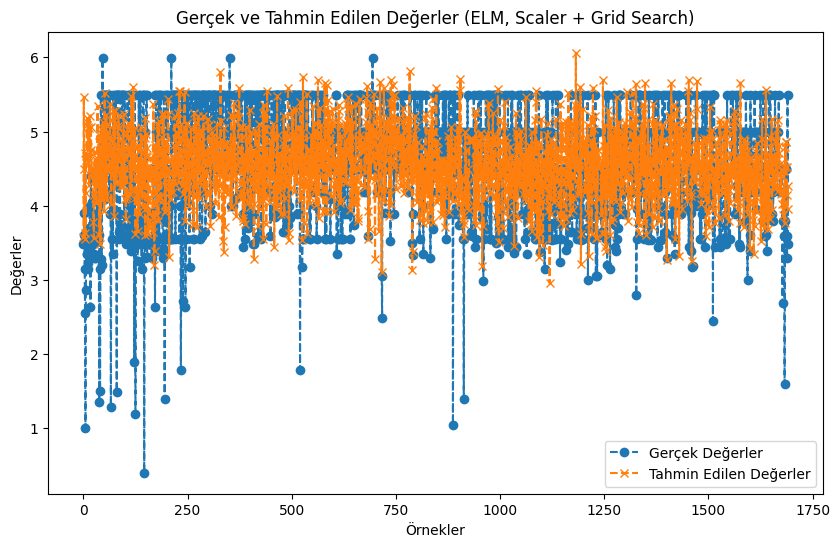

In [9]:
# Gerçek ve tahmin edilen değerlerin grafiği
plt.figure(figsize=(10, 6))
plt.plot(range(len(y)), y, label="Gerçek Değerler", marker="o", linestyle="--")
plt.plot(range(len(y_pred)), y_pred, label="Tahmin Edilen Değerler", marker="x", linestyle="--")
plt.xlabel("Örnekler")
plt.ylabel("Değerler")
plt.title("Gerçek ve Tahmin Edilen Değerler (ELM, Scaler + Grid Search)")
plt.legend()
plt.show()
